# Loop data, Part 3: Exploring CGM data (daily stats, etc)

Before I put the CGM and Loop datasets together, I want to first just explore the CGM dataset, and think about the types of statistics and summary information I want to pull out of the CGM set. I also have some previous code that I wrote to do really basic visualizations in terms of time in range per day, for example. 

In [2]:
import sys
sys.path.append("../")

from mdb_tools import load_data as ld
from mdb_tools import schemas
from mdb_tools import loop_stats as oop
from mdb_tools import sugar_plots as sp

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib widget

In [3]:
yml_secrets_file = '../../secrets/mdb_secrets.yml'

# Access the database using the yml secrets file, and get a specific set of "collections"
col_entries, col_treatments, col_profile, col_devicestatus = ld.get_collections(yml_secrets_file)

# Grab schemas
entries_schema, treatments_schema, devicestatus_schema = schemas.mdb_schemas()

# Load
df_entries = col_entries.find_pandas_all({}, schema=entries_schema)
df_treatments = col_treatments.find_pandas_all({}, schema=treatments_schema)
df_devicestatus = col_devicestatus.find_pandas_all({}, schema=devicestatus_schema)

# Convert the time string to datetime format (not converting time zone this time!)
df_entries["time"] = pd.to_datetime(df_entries["dateString"])


With only a little bit of fussing, I managed to grab the code I wrote previously to plot time in range. I had to adjust it to accept more generic input arguments, but it pretty much works as it's meant to. The only issue is that we have a really large gap in the data between early August and late September (when we started Looping). Not sure what happened there, and not sure those data are recoverable.

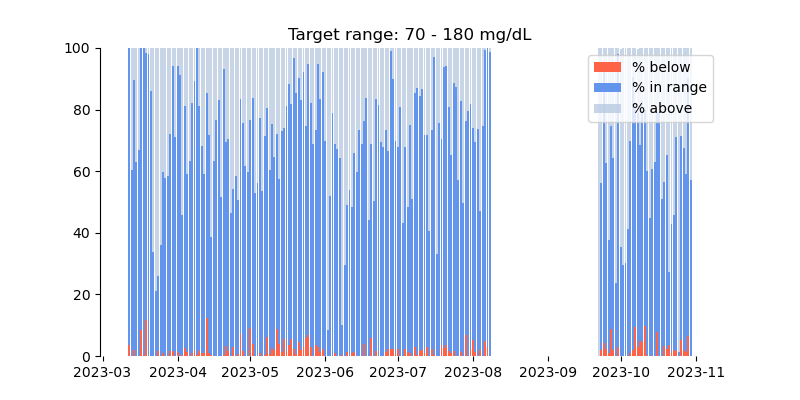

In [4]:
df_cgm_daily = oop.daily_cgm_stats(df_entries["time"], df_entries["sgv"])

sp.daily_tir(df_entries["time"], df_entries["sgv"]);

# Attempt to pull loop settings at specific times

Let's see if I can pull together the things I've been building... I've got CGM data at specific times, and I've functions that return the loop settings at any requested set of times. Seems promising!


In [5]:
in_times = df_entries["time"]
bg = df_entries["sgv"]

# Pulling settings at each CGM time - making sure it's working!
basal = oop.get_setting_at_times(in_times, col_profile, req_setting = "basal", req_profile = "Default")
carb_ratio = oop.get_setting_at_times(in_times, col_profile, req_setting = "carbratio", req_profile = "Default")
sens = oop.get_setting_at_times(in_times, col_profile, req_setting = "sens", req_profile = "Default")

df_bg = pd.DataFrame(np.transpose([in_times.dt.tz_convert('US/Eastern'), bg, basal, carb_ratio, sens]), 
                                  columns=['time', 'bg', 'basal', 'carb_ratio', 'sens'],
                                  index=in_times.dt.tz_convert('US/Eastern')).dropna()

# Sort the time indices
df_bg.sort_index(inplace=True)

In [6]:
df_bg.head()

,time,bg,basal,carb_ratio,sens
time,,,,,
2023-03-12 12:48:42-04:00,2023-03-12 12:48:42-04:00,89.0,0.3,12,150
2023-03-12 12:53:43-04:00,2023-03-12 12:53:43-04:00,90.0,0.3,12,150
2023-03-12 12:58:42-04:00,2023-03-12 12:58:42-04:00,89.0,0.3,12,150
2023-03-12 13:03:42-04:00,2023-03-12 13:03:42-04:00,90.0,0.3,12,220
2023-03-12 13:08:42-04:00,2023-03-12 13:08:42-04:00,93.0,0.3,12,220


### BG vs time

The next three plots are all just showing the same thing - BG vs time, just looking at it using different plotting methods. First, a plain matplotlib plot. Second, a plot built using hvplot. Third, a built-in hvplot interactive plot where you have some additional GUI controls for exploring the dataframe.

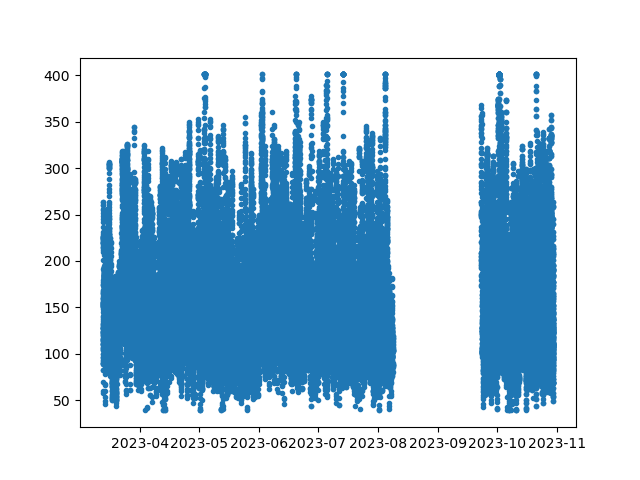

In [7]:
fig2, ax2 = plt.subplots(1,1)
ax2.plot(in_times, bg, '.');


In [8]:
import hvplot.pandas #noqa

df_bg.hvplot.scatter(x='time', y='bg')

:Scatter   [time]   (bg)

In [9]:
explorer = df_bg.hvplot.explorer(x='time', y='bg', kind='scatter', by=['sens'])
explorer

hvDataFrameExplorer(advanced=Advanced(explorer=..., name='Advanced01242', opts={}), axes=Axes(explorer=..., height=None, legend='right', logx=False, logy=False, name='Axes00963', responsive=True, shared_axes=True, width=None, xlim=None, ylim=None), by=['sens'], code="df.hvplot(\n    by=['sens'],\n    kind='scatter',\n    x='time',\n    y=['bg'],\n)", colormapping=Colormapping(clim=None, cmap='kbc_r', cnorm='linear', color=None, colorbar=None, explorer=..., name='Colormapping01023', rescale_discrete_levels=True, symmetric=False), geographic=Geographic(crs=None, crs_kwargs={}, explorer=..., feature_scale='110m', features=None, geo=False, global_extent=None, name='Geographic01114', project=False, projection=None, projection_kwargs={}, tiles=None), groupby=[], kind='scatter', labels=Labels(clabel='', explorer=..., fontscale=1, name='Labels01070', rot=0, title='', xlabel='', ylabel=''), name='hvDataFrameExplorer00913', operations=Operations(aggregator=None, datashade=False, dynspread=False, explorer=..., name='Operations01174', rasterize=False, x_sampling=None, y_sampling=None), statusbar=StatusBar(live_update=True, name='StatusBar00946'), style=Style(alpha=1, explorer=..., name='Style01218'), x='time', y='bg', y_multi=['bg'], z=None)

## Splitting out time chunks

I am not really that interested in the earlier data - before that big gap. We didn't have Loop set up during that time period so there's less to look at on that side of things. And the newer data are more relevant to determining how to update treatment settings etc. 

So now I'm going to make a little function that pulls out only the time period I'm intrested in. 

In [10]:
df_sub = df_bg.loc['2023-09-27':]
df_sub.head()

,time,bg,basal,carb_ratio,sens
time,,,,,
2023-09-27 00:03:51-04:00,2023-09-27 00:03:51-04:00,139.0,0.3,15,250
2023-09-27 00:03:52-04:00,2023-09-27 00:03:52-04:00,139.0,0.3,15,250
2023-09-27 00:08:51-04:00,2023-09-27 00:08:51-04:00,141.0,0.3,15,250
2023-09-27 00:08:52-04:00,2023-09-27 00:08:52-04:00,141.0,0.3,15,250
2023-09-27 00:13:51-04:00,2023-09-27 00:13:51-04:00,140.0,0.3,15,250


In [11]:
df_sub.hvplot.scatter(x='time', y='bg')

:Scatter   [time]   (bg)